In [1]:
import os, random
import numpy as np
import cv2

In [2]:
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
ia.seed(2)

In [3]:
base_dir = '/home/ai_competition36'
img_dir = os.path.join(base_dir, 'backsub_images')
txt_dir = os.path.join(base_dir, 'backsub_txts')
#modified_dir = base_dir + '/1.competition_trainset/modified1' # 합성된 사진은 modified폴더에 저장
backgrounds_dir = os.path.join(base_dir, 'backgrounds') # 배경은 backgrounds 폴더에 저장

In [4]:
#두 이미지를 합성, img1이 아래에, img2가 위에 합성됨
#주의! 모든 이미지는 (460, 640, 3) 의 크기여야 함
#input은 cv2.imread로 읽어들인 이미지 파일
def addimage(img1, img2):
  rows, cols, channels = img2.shape

  img2gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
  mask_inv = cv2.bitwise_not(mask)

  img1_bg = cv2.bitwise_and(img1, img1, mask=mask_inv)

  img2_fg = cv2.bitwise_and(img2, img2, mask=mask)

  return cv2.add(img1_bg, img2_fg)

In [5]:
#설정한 x,y만큼 이미지를 이동, 이때 원점은 이미지의 좌측 상단 꼭짓점 기준임
def move(img, x, y):
  h, w = img.shape[:2]
  M = np.float32([[1, 0 ,x],[0, 1, y]])
  return cv2.warpAffine(img, M, (w, h))

In [6]:
#주어진 이미지를 (480, 640, 3)크기로 축소 
def resize(img):
    res = cv2.resize(img, dsize=(640, 480), interpolation=cv2.INTER_AREA)
    return res

In [38]:
# jpg파일 인가?
#def isjpg(path):
#  root, extension = os.path.splitext(path)
#  if extension == '.jpg':
#    return True
#  else:
#    return False

In [7]:
#itemlist = os.listdir(img_dir)
#print(itemlist)

['13.cheeze_it', '42.pepperidge_farm_milano_cookies_double_chocolate', '14.hersheys_bar', '43.campbells_chicken_noodle_soup', '44.frappuccino_coffee', '15.redbull', '45.chewy_dips_chocolate_chip', '16.mom_to_mom_sweet_potato_corn_apple', '46.chewy_dips_peanut_butter', '17.a1_steak_sauce', '47.nature_vally_fruit_and_nut', '18.jif_creamy_peanut_butter', '48.cheerios', '19.cinnamon_toast_crunch', '49.lindt_excellence_cocoa_dark_chocolate', '5.hersheys_cocoa', '50.hersheys_symphony', '51.campbells_chunky_classic_chicken_noodle', '52.martinellis_apple_juice', '53.dove_pink', '54.dove_white', '21.dr_pepper', '55.david_sunflower_seeds', '22.haribo_gold_bears_gummi_candy', '56.monster_energy', '57.act_ii_butter_lovers_popcorn', '23.bulls_eye_bbq_sauce_original', '24.reeses_pieces', '58.coca_cola_bottle', '25.clif_crunch_peanut_butter', '59.twix', '26.mom_to_mom_butternut_squash_pear', '6.honey_bunches_of_oats_honey_roasted', '2.bumblebee_albacore', '27.pop_trarts_strawberry', '7.honey_bunches_

In [40]:
#txt폴더 만들기~
#for item in itemlist:
#    os.makedirs(os.path.join(txt_dir, item))

In [41]:
#import shutil

In [42]:
#txt폴더로 txt파일 옮기기~
#for item in itemlist:
#    filepath = os.path.join(img_dir, item)
#    filelist = os.listdir(filepath)
#    for file in filelist:
#        if isjpg(file)==False:
#            shutil.move(filepath + '/' + file, txt_dir + '/' + item + '/' + file)

# 여러 개의 물체를 겹치고 배경과 합성
## 합성할 물체는 2~4개 중 랜덤으로 결정

In [12]:
#iternum = 6000 # 만들파일의 개수, 실제로 한다면 최소 10만장정도??

item_list = os.listdir(img_dir)

print('start iteration')
count=0

''' # 1개에 배경 합성하는 코드
modified_dir = base_dir + '/1.competition_trainset/modified1'

for item in item_list:
    sample_item_path=os.path.join(img_dir,item)
    sample_img_list=os.listdir(sample_item_path)
    for sample in sample_img_list:
            sample_path=os.path.join(sample_item_path,sample)
            base_img=cv2.imread(sample_path)
            
            background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
            background_img = cv2.imread(background_img_path)
            base_img = addimage(background_img, base_img)
            
            file_name = f'/{count}+background'
            cv2.imwrite(modified_dir + file_name + '.jpg', base_img)
            
            txt_path = os.path.join(txt_dir,item, sample[0:-3] + 'txt')
            f = open(txt_path, 'r')
            line = f.readline()
            f.close()
            
            fw = open(modified_dir + file_name + '.txt', 'w')
            fw.write(line)
            fw.close()
            
            count+=1
            if count % 1000 == 0:
                print(f'iteration {count}times complete')
                
print('All iteration complete')
'''
# 2개 이상의 이미지 합성하는 과정

for item in item_list:                         # item은 60개의 폴더이름 중 하나
    sample_item_path=os.path.join(img_dir,item)
    sample_img_list=os.listdir(sample_item_path)
    ex_item_list = [x for x in item_list if x!=item]
    for sample in sample_img_list:             # sample은 폴더 안의 100장의 이미지 이름 중 하나
            img_path_list = []                  # img_path_list 는 item/sample 형식
            square_list = []                    # square_list 는 bounding box 넓이 저장
            lines = [] # txt파일 정보 저장
            
            sample_path=os.path.join(item, sample)
            
            img_path_list.append(sample_path)
            
            n = 3                                 # 합성할 사진 개수 (기본 1개 + n개) 총 1+n개 물체
            modified_dir = base_dir + '/1.competition_trainset/modified4' # 합성된 사진은 modified폴더에 저장
            composeitem = random.sample(ex_item_list, n) # 합성할 아이템 뽑기 
            
            for compose_item in composeitem:
                    compose_item_path = os.path.join(img_dir, compose_item)
                    compose_img_list = os.listdir(compose_item_path)
                    compose_img_name = random.choice(compose_img_list)
                    img_path_list.append(os.path.join(compose_item, compose_img_name))
            #print(img_path_list)

            for img_path in img_path_list:
                txt_path = os.path.join(txt_dir, img_path[0:-3] + 'txt')
                f = open(txt_path, 'r')
                line = f.readline()
                line = line.strip() # 줄 끝의 줄 바꿈 문자 제거
                lines.append(line)  # 각 물체의 txt파일의 바운딩 박스 정보를 lines리스트에 저장
                b = line.split()  
                area = float(b[3])*float(b[4])*100
                square_list.append(area)
                f.close()
            
            dictionary = dict(zip(img_path_list, square_list))
            sorted_dictionary = dict(sorted(dictionary.items(), key=lambda x:x[1], reverse=True)) # 딕셔너리 정렬
            sorted_img_list = list(sorted_dictionary)
            
            base_img = cv2.imread(os.path.join(img_dir, sorted_img_list[0]))
            for i in range(1,n+1):
                compose_img = cv2.imread(os.path.join(img_dir, sorted_img_list[i]))
                base_img = addimage(base_img, compose_img)
                
            background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
            background_img = cv2.imread(background_img_path)
            base_img = addimage(background_img, base_img)
            
            file_name = f'/{n+1}_{count}+background'
            cv2.imwrite(modified_dir + file_name + '.jpg', base_img)

            #저장된 txt파일 정보 modified폴더에 저장하기
            fw = open(modified_dir + file_name + '.txt', 'w')
            fw.write(lines[0])
            for j in range(1,n+1):
                fw.write('\n'+lines[j])
            fw.close()
            
            count+=1
            if count % 1000 == 0:
                print(f'iteration {count}times complete')
                
print('All iteration complete')


start iteration
iteration 1000times complete
iteration 2000times complete
iteration 3000times complete
iteration 4000times complete
iteration 5000times complete
iteration 6000times complete
All iteration complete


In [ ]:
'''
for times in iternum:
  n = random.choice([2,3,4]) # 합성할 물체의 수를 2~4개 중 랜덤으로 설정
  sampleitem = random.sample(item_list, n) # 랜덤으로 합성할 아이템 2~4개 고름

  #각각의 아이템에 대해서 랜덤한 이미지 선택
  #img_path_list = []
  for item in sampleitem:
    sample_item_path = os.path.join(img_dir, item)
    sample_img_list = os.listdir(sample_item_path)
    sample_img_name = random.choice(sample_img_list)
    sample_img_path = os.path.join(sample_item_path, sample_img_name)
    img_path_list.append(os.path.join(item, sample_img_name))
  print(img_path_list)

  # txt파일을 열어 대응되는 bounding box 넓이 리스트 만들기
  square_list = []
  lines = [] # txt파일 정보 저장
  for img_path in img_path_list:
    txt_path = os.path.join(txt_dir, img_path[0:-3] + 'txt')
    f = open(txt_path, 'r')
    line = f.readline()
    line = line.strip() # 줄 끝의 줄 바꿈 문자 제거
    lines.append(line)
    b = line.split()  
    area = float(b[3])*float(b[4])*100
    square_list.append(area)
    f.close()
  #print(square_list)

  # 이미지 리스트와 넓이 리스트를 합쳐 딕셔너리로 만들기
  dictionary = dict(zip(img_path_list, square_list))
  #print(dictionary)
  sorted_dictionary = dict(sorted(dictionary.items(), key=lambda x:x[1], reverse=True)) # 딕셔너리 정렬
  #print(sorted_dictionary)

  #넓이가 큰 순서대로 정렬된 이미지 리스트 얻음
  sorted_img_list = list(sorted_dictionary)
  #print(sorted_img_list)

  # 정렬된 리스트를 기준으로 순서대로 합치기(이미지)
  base_img = cv2.imread(os.path.join(img_dir, sorted_img_list[0]))
  for i in range(1,n):
    sample_img = cv2.imread(os.path.join(img_dir, sorted_img_list[i]))
    base_img = addimage(base_img, sample_img)
  #cv2_imshow(base_img)

  # 배경 이미지 랜덤으로 가져와서 함성하기, 34 * 4 = 136장 중 하나
  background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
  background_img = cv2.imread(background_img_path)
  base_img = addimage(background_img, base_img)
    
  #이미지 파일 저장!
  file_name = f'/first_trial{times}'
  cv2.imwrite(modified_dir + file_name + '.jpg', base_img)

  #저장된 txt파일 정보 modified폴더에 저장하기
  fw = open(modified_dir + file_name + '.txt', 'w')
  #print(lines)
  fw.write(lines[0])
  for j in range(1,n):
    fw.write('\n'+lines[j])
  fw.close()

  if times % 1000 == 0:
    print(f'iteration {times}times complete')
    
print('All iteration complete')
'''

In [13]:
os.listdir(base_dir + '/1.competition_trainset/modified4')

['4_0+background.jpg',
 '4_0+background.txt',
 '4_1+background.jpg',
 '4_1+background.txt',
 '4_2+background.jpg',
 '4_2+background.txt',
 '4_3+background.jpg',
 '4_3+background.txt',
 '4_4+background.jpg',
 '4_4+background.txt',
 '4_5+background.jpg',
 '4_5+background.txt',
 '4_6+background.jpg',
 '4_6+background.txt',
 '4_7+background.jpg',
 '4_7+background.txt',
 '4_8+background.jpg',
 '4_8+background.txt',
 '4_9+background.jpg',
 '4_9+background.txt',
 '4_10+background.jpg',
 '4_10+background.txt',
 '4_11+background.jpg',
 '4_11+background.txt',
 '4_12+background.jpg',
 '4_12+background.txt',
 '4_13+background.jpg',
 '4_13+background.txt',
 '4_14+background.jpg',
 '4_14+background.txt',
 '4_15+background.jpg',
 '4_15+background.txt',
 '4_16+background.jpg',
 '4_16+background.txt',
 '4_17+background.jpg',
 '4_17+background.txt',
 '4_18+background.jpg',
 '4_18+background.txt',
 '4_19+background.jpg',
 '4_19+background.txt',
 '4_20+background.jpg',
 '4_20+background.txt',
 '4_21+backg

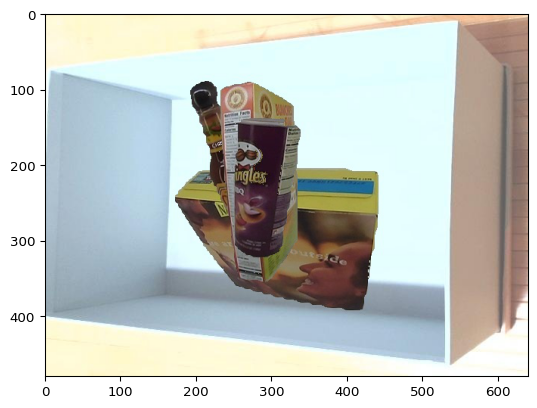

In [14]:
ex_dir = base_dir + '/1.competition_trainset/modified4'
img = imageio.imread(ex_dir + '/4_1006+background.jpg')
ia.imshow(img)

In [15]:
xt_dir = os.path.join(os.path.join(ex_dir, '4_1006+background.txt'))
with open (xt_dir, 'r') as myfile:
    data = myfile.readlines()
print(data)

['47 0.4765625 0.6229166666666667 0.43125 0.3958333333333333\n', '3 0.39453125 0.42916666666666664 0.1953125 0.4875\n', '6 0.428125 0.4625 0.171875 0.5458333333333333\n', '12 0.4609375 0.47604166666666664 0.14375 0.3729166666666667']
